/tmp/ipykernel_136139/1149474735.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)


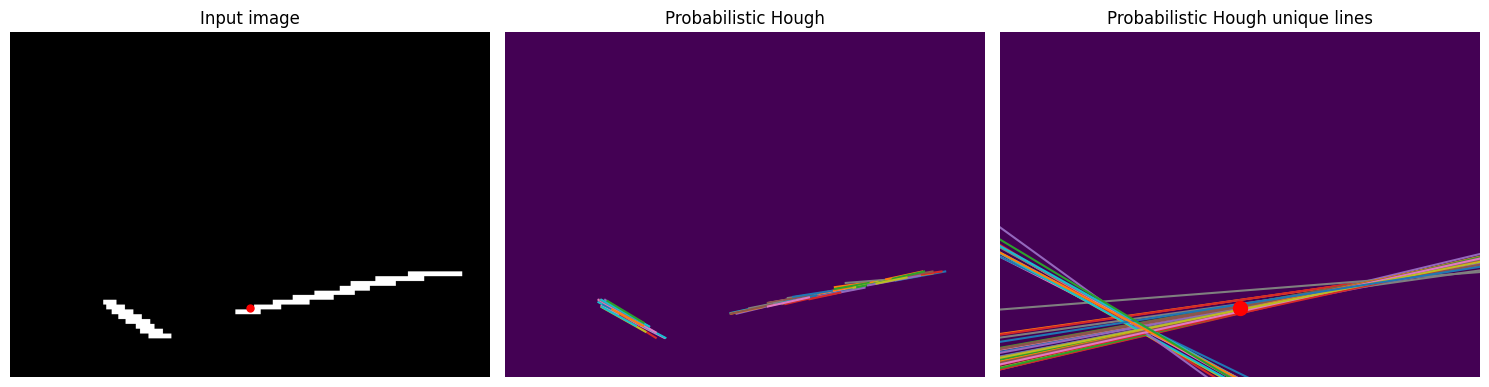

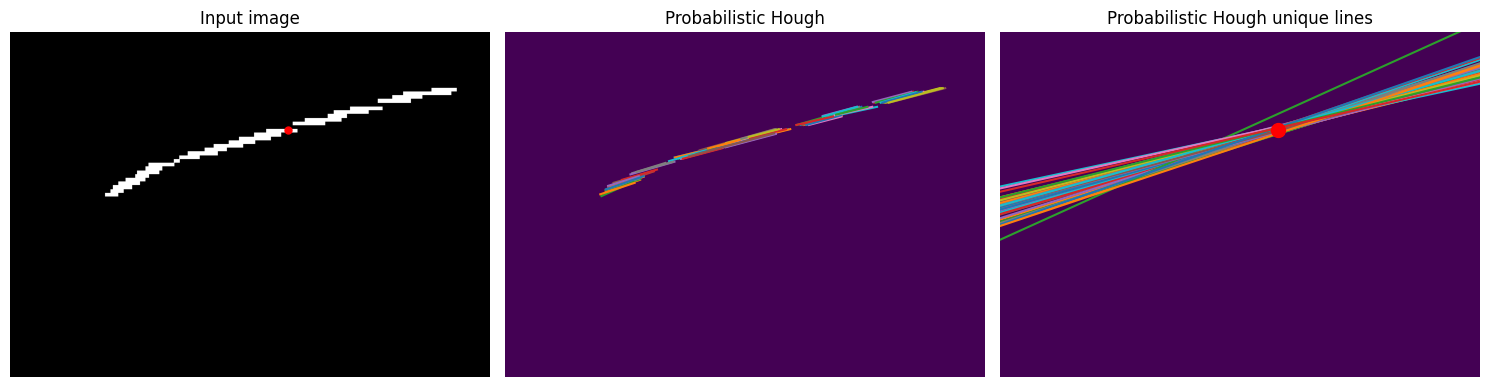

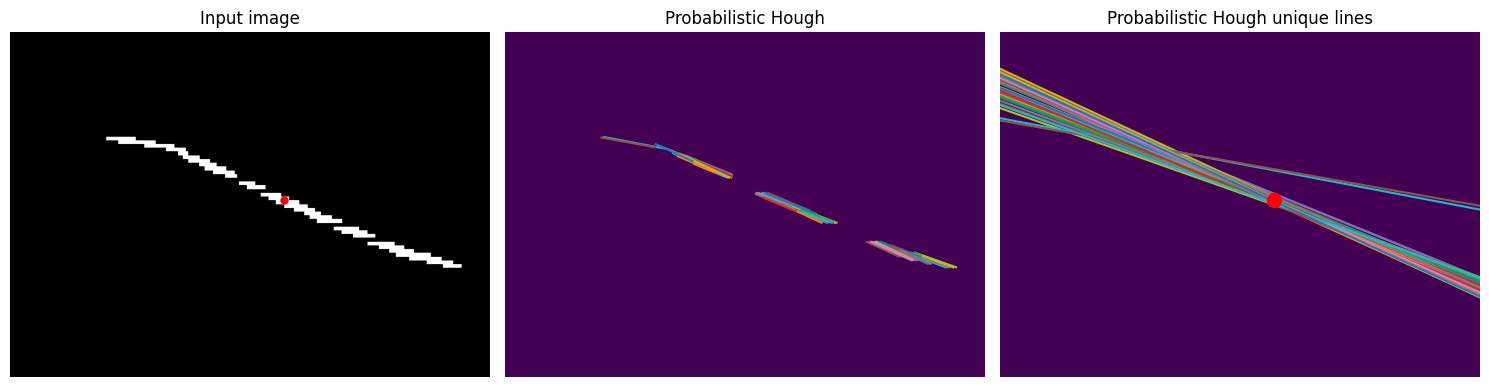

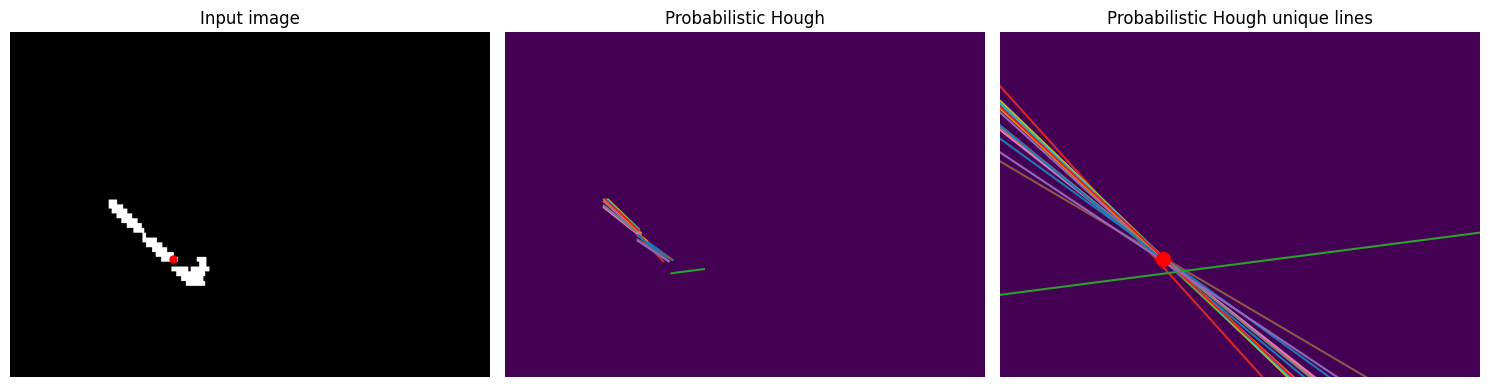

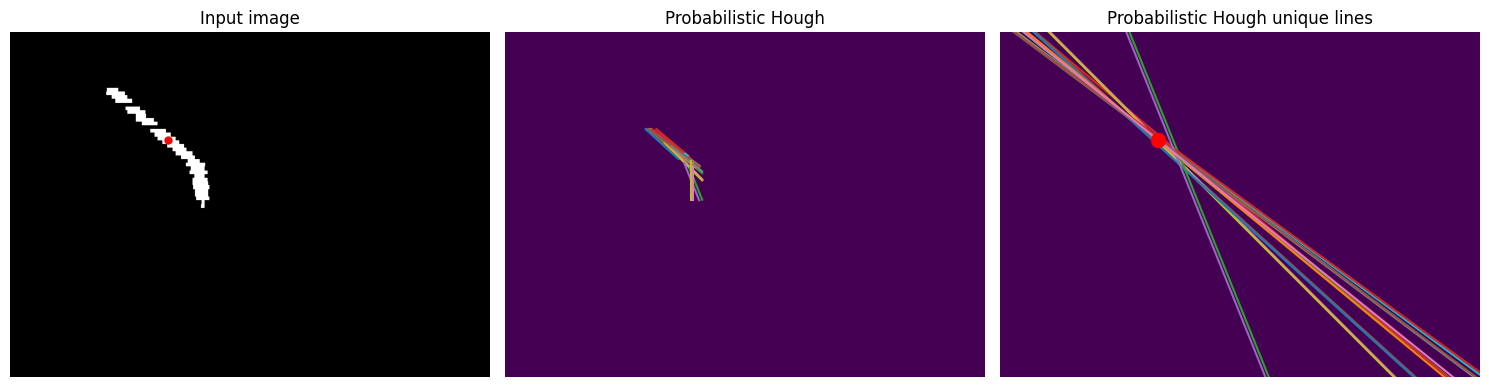

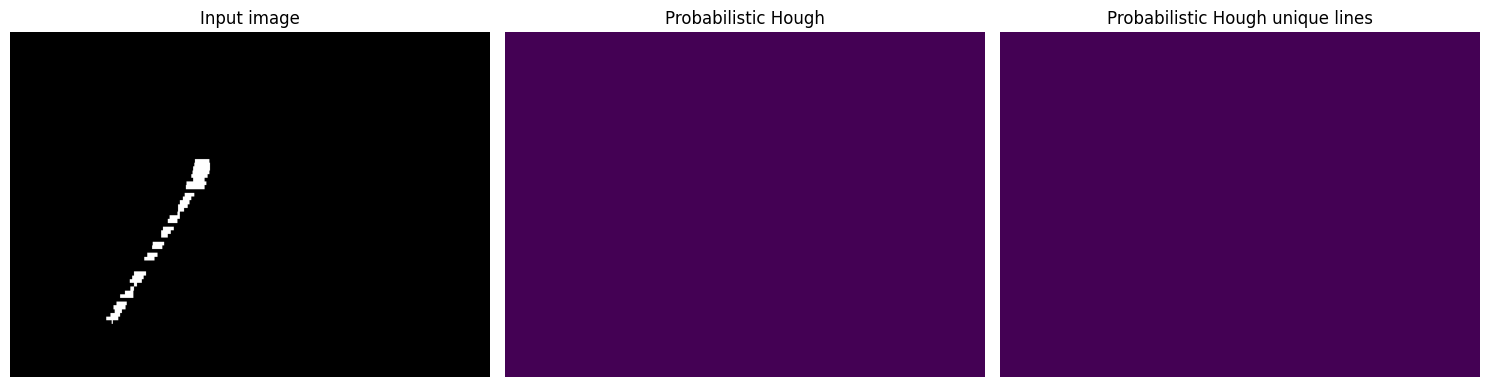

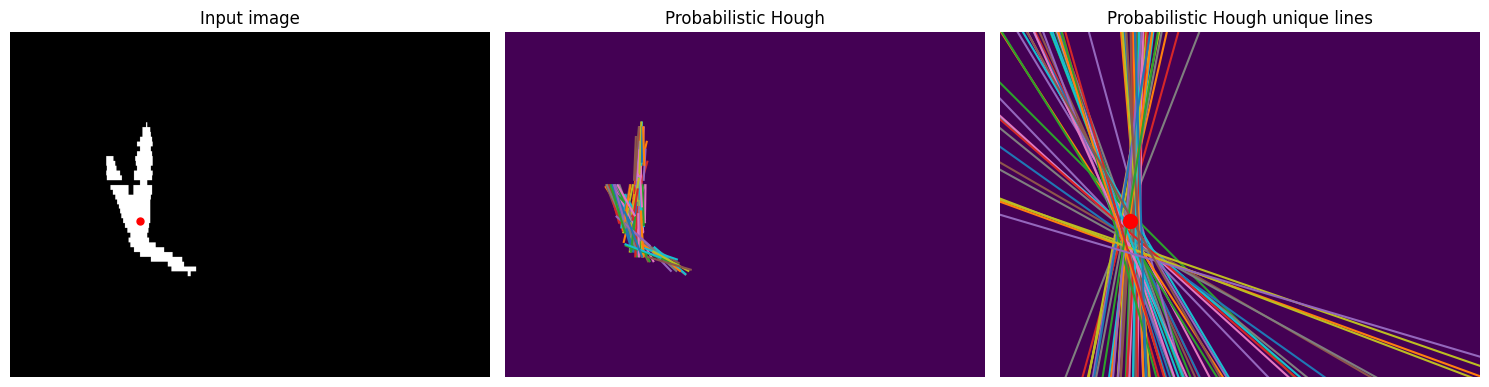

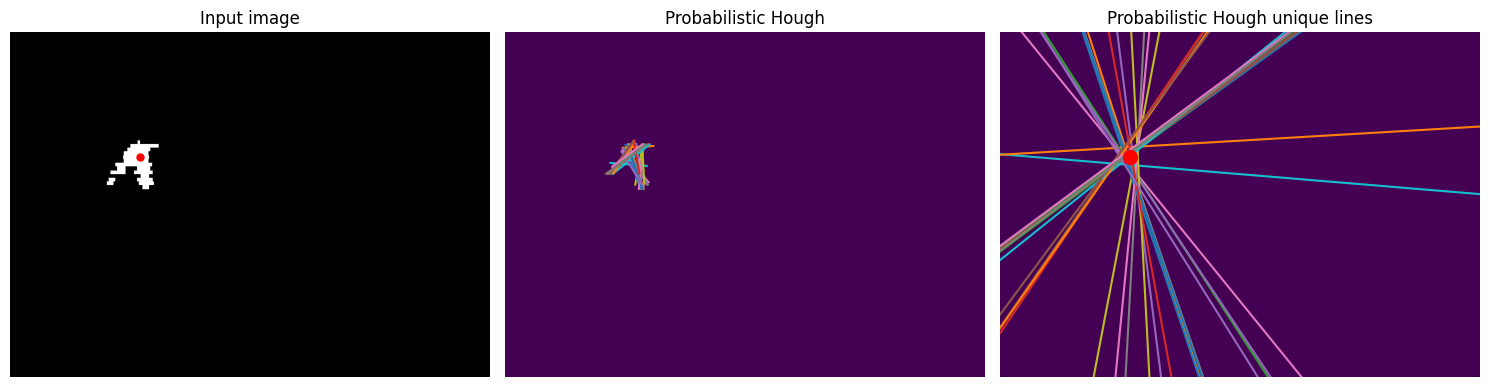

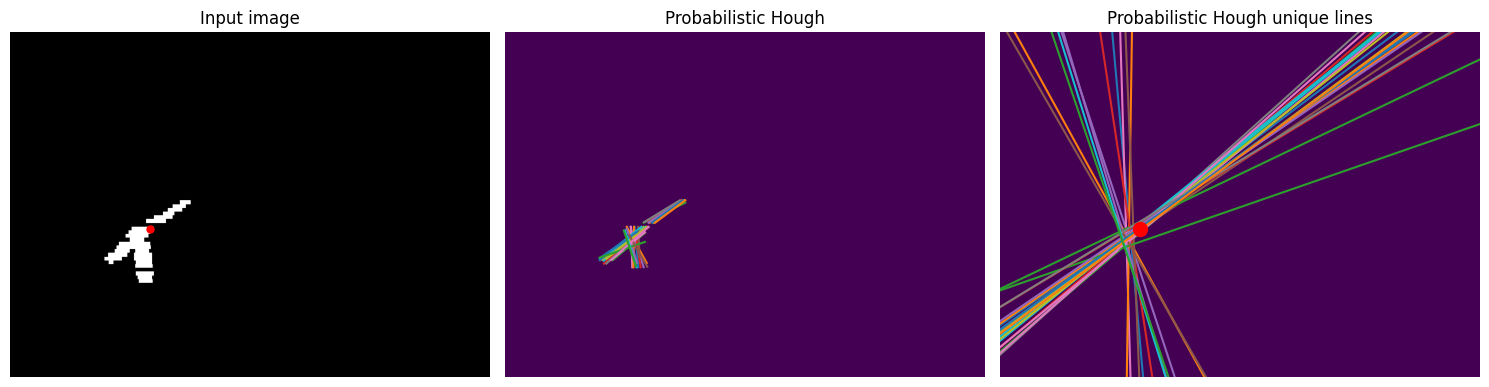

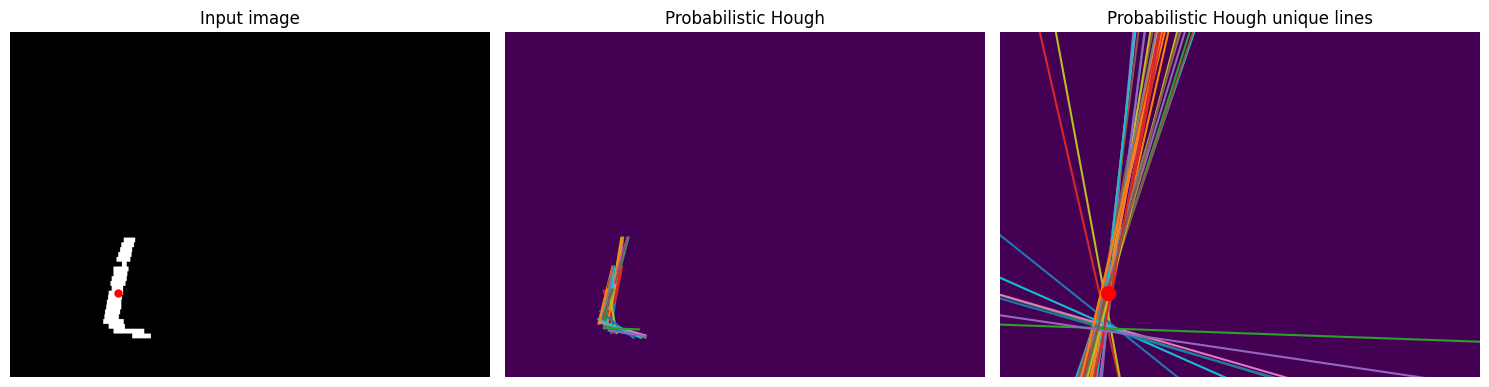

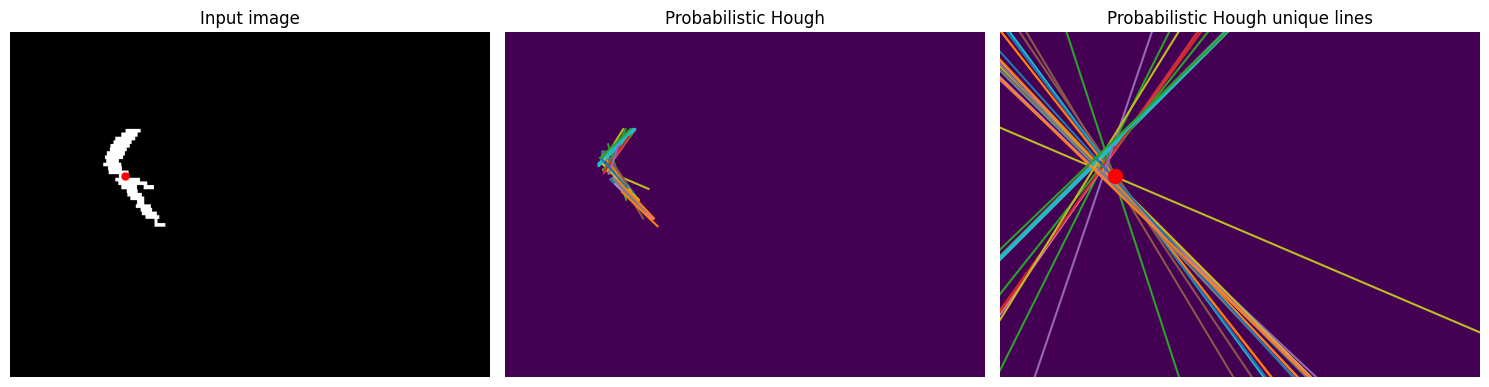

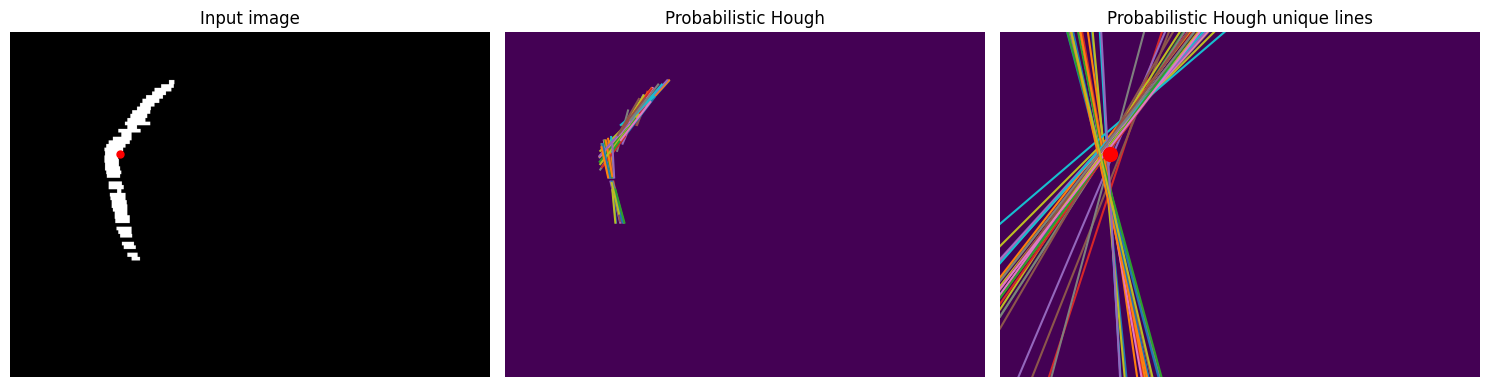

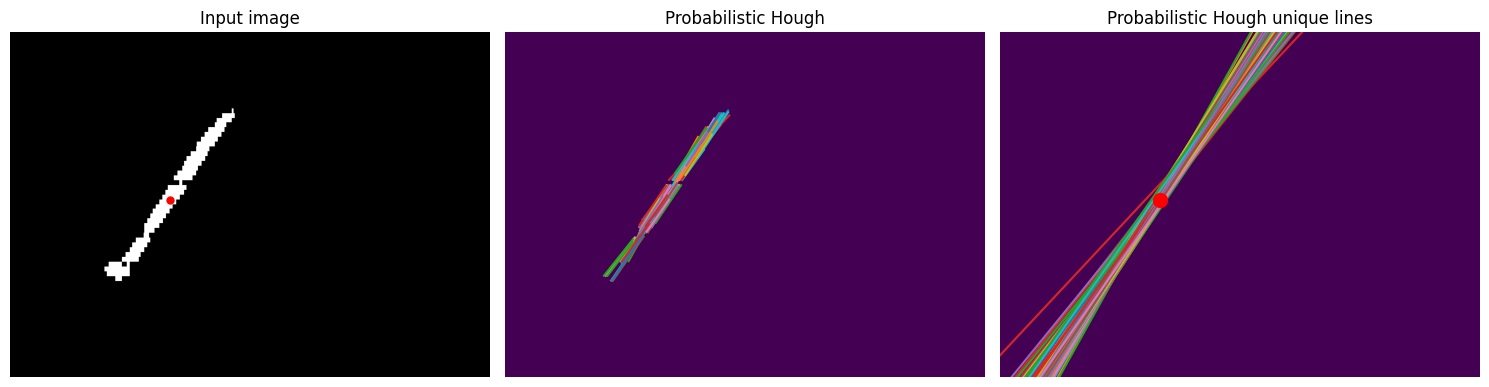

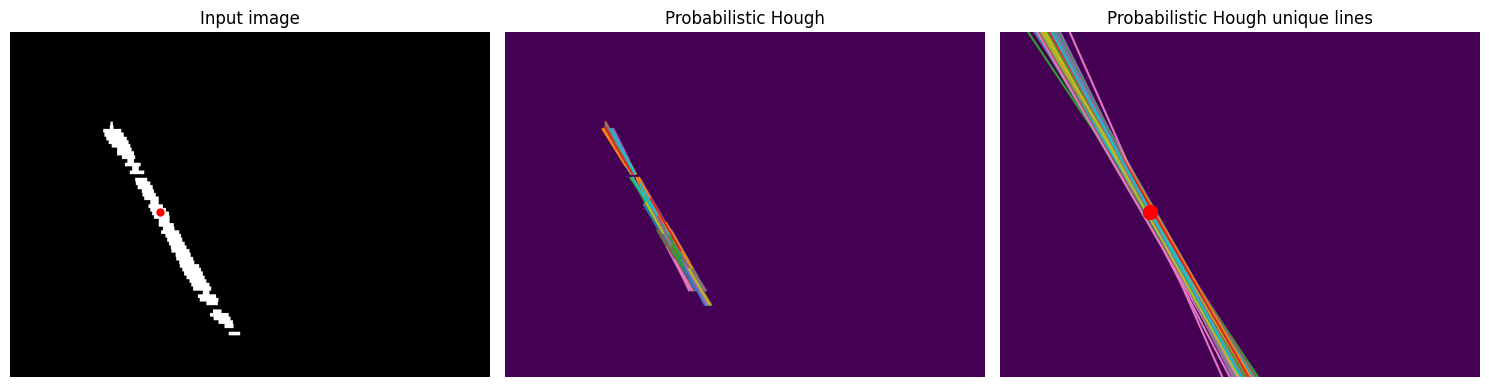

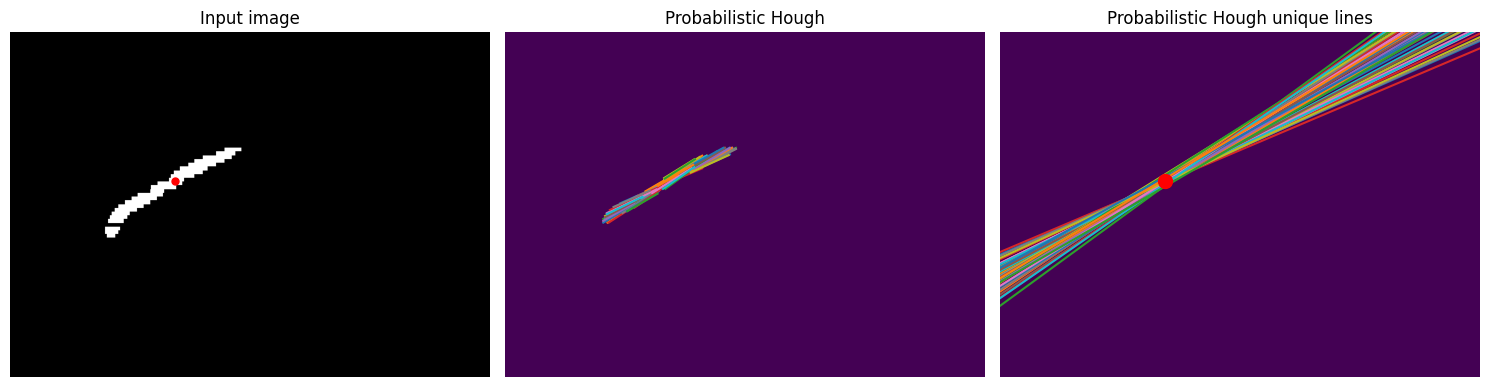

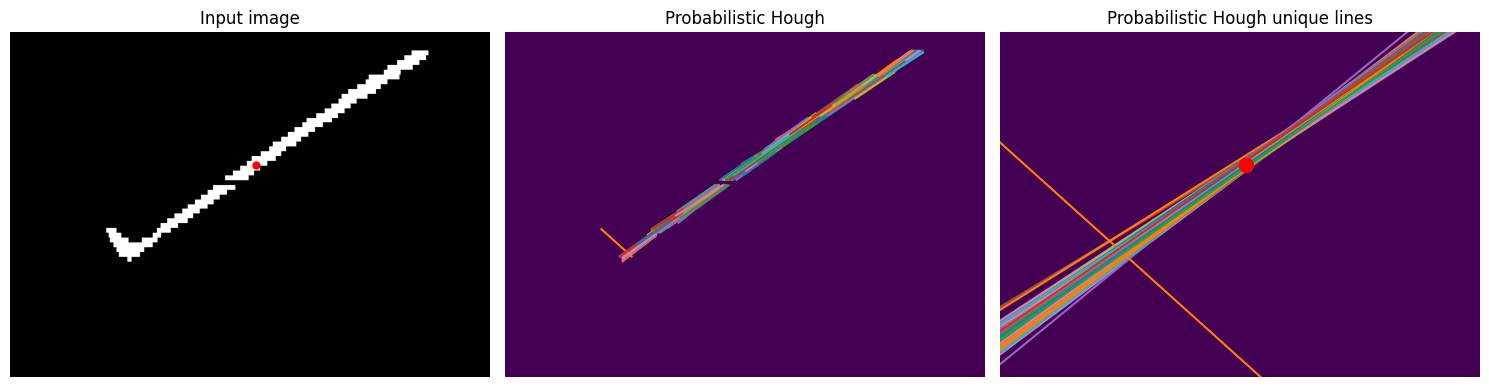

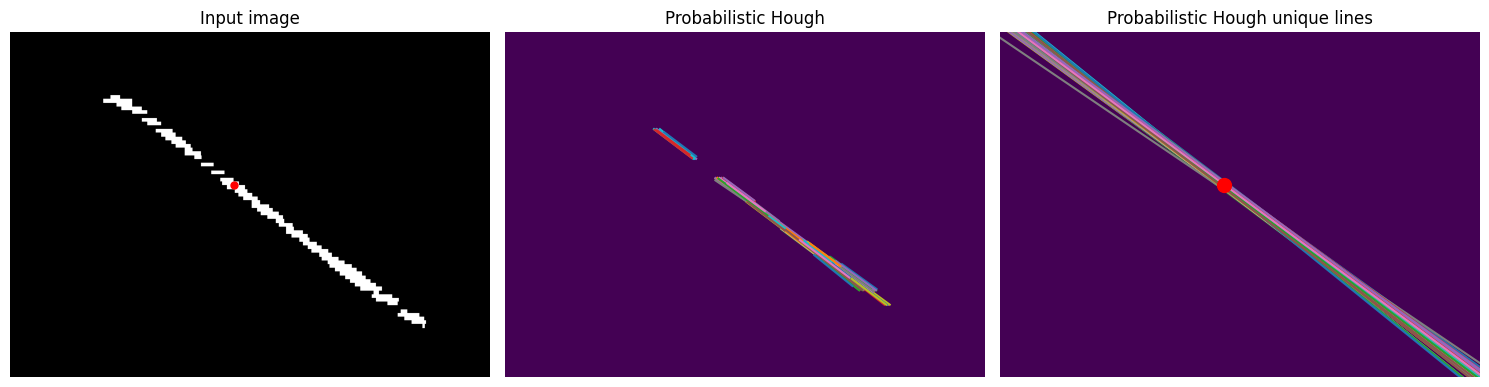

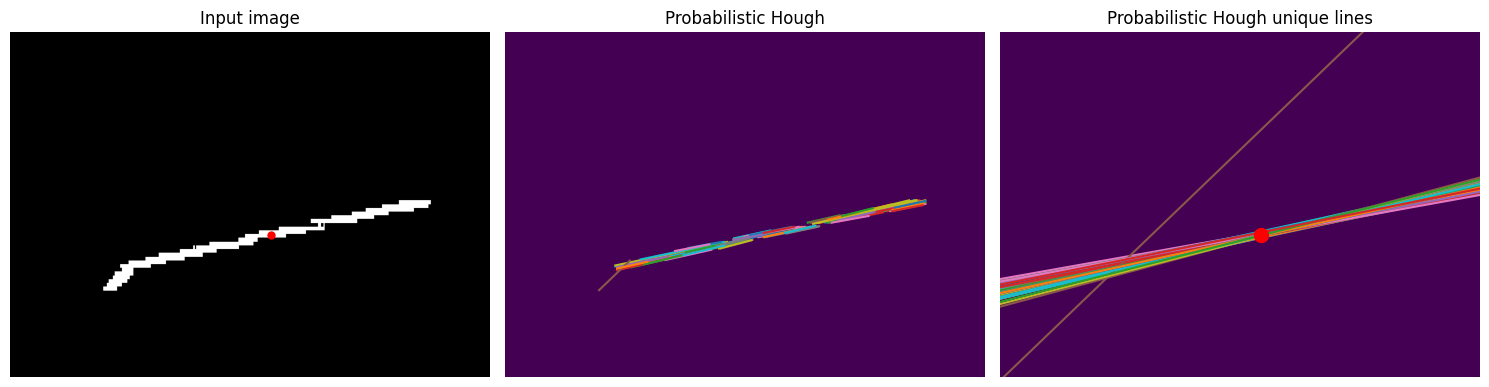

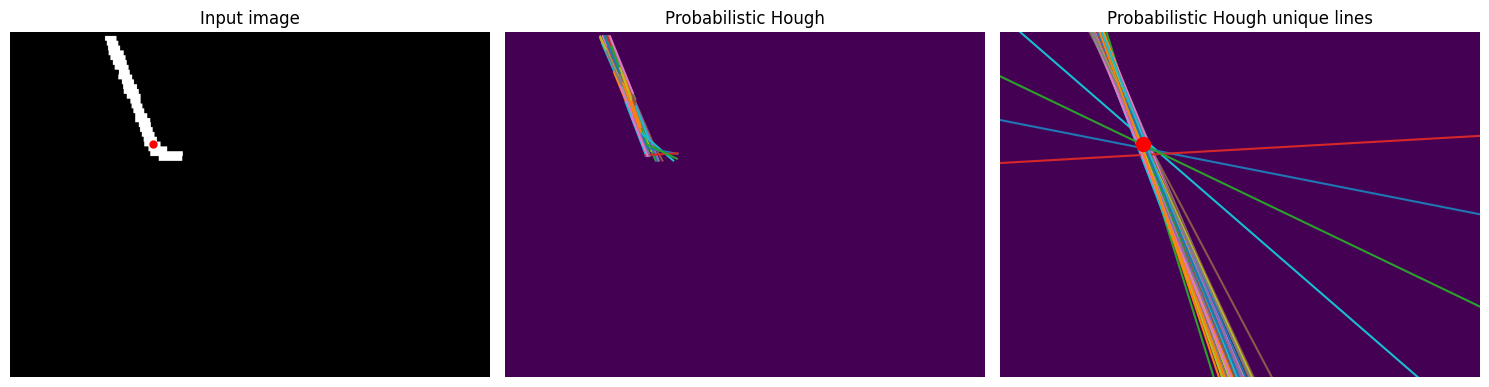

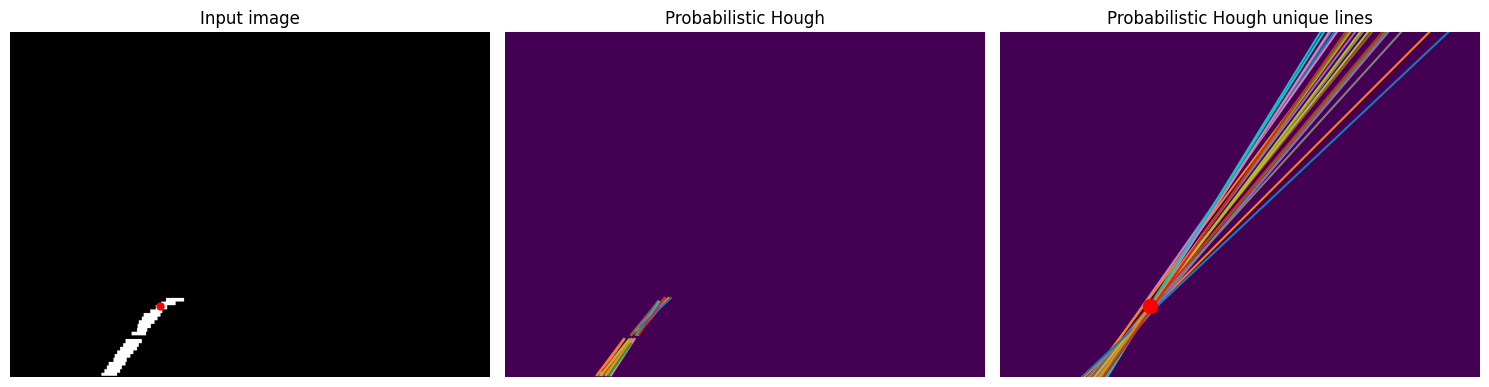

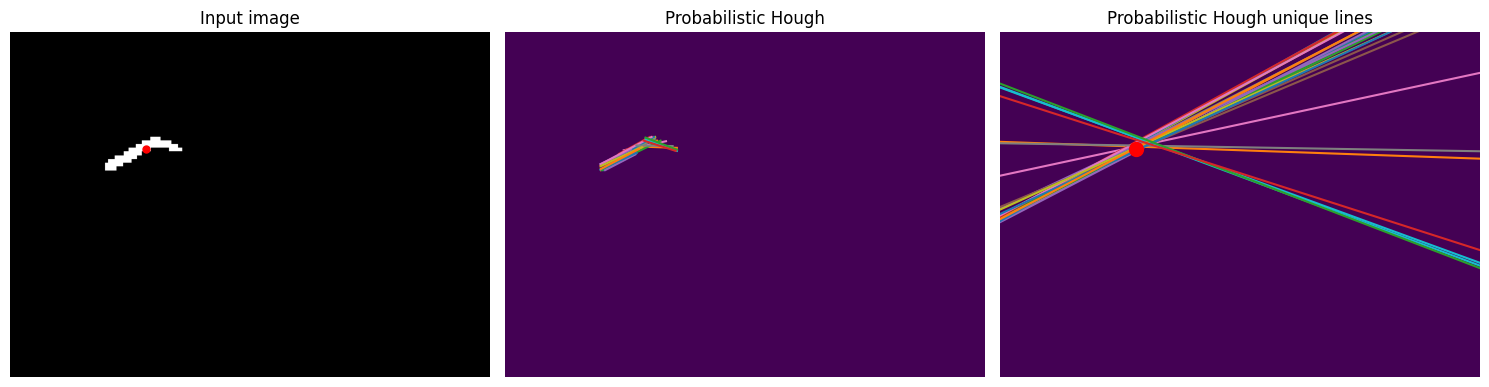

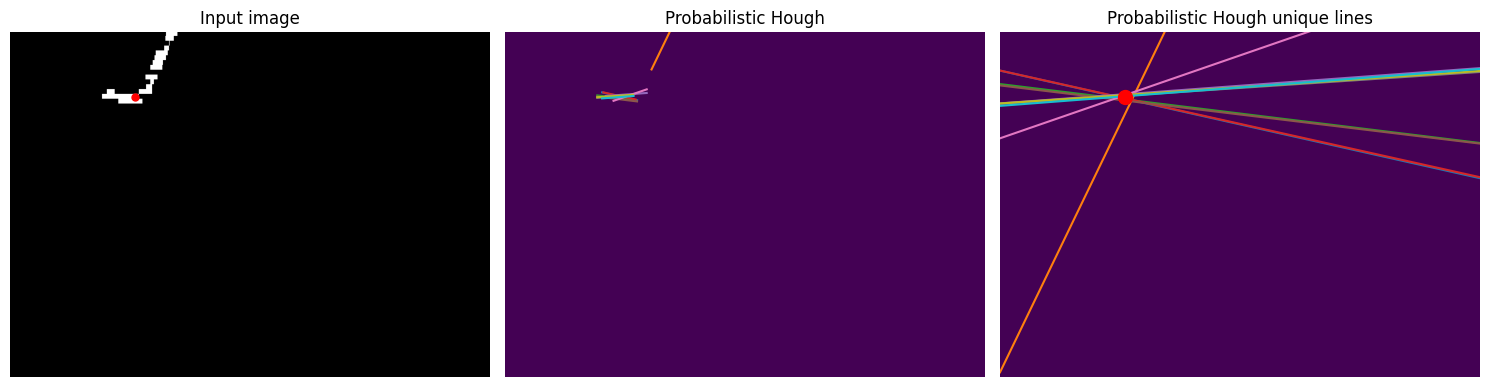

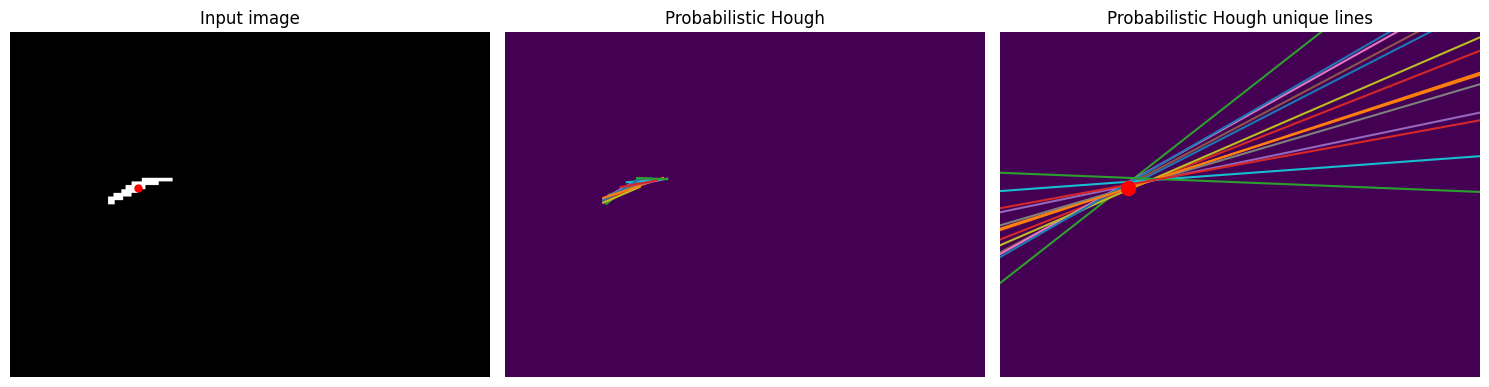

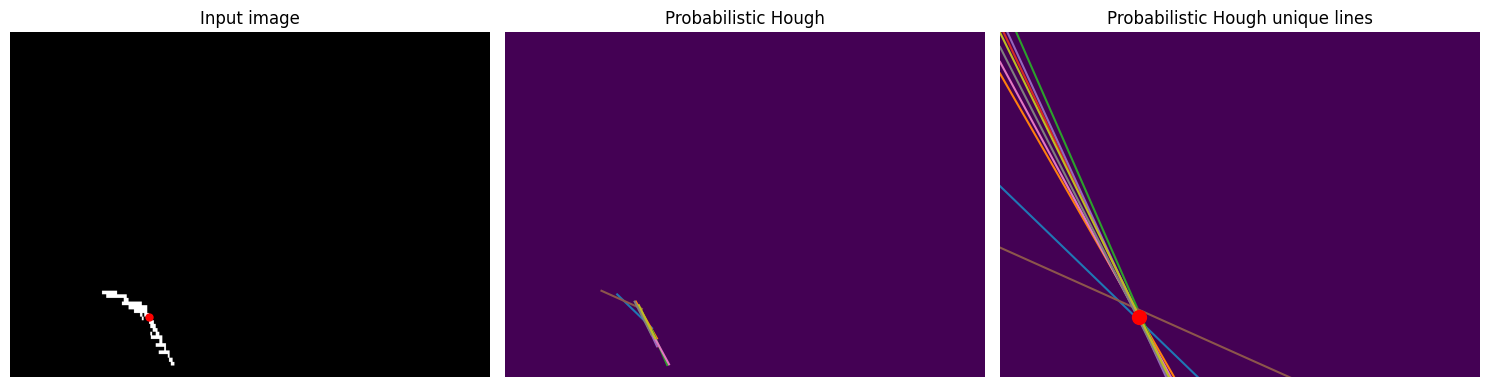

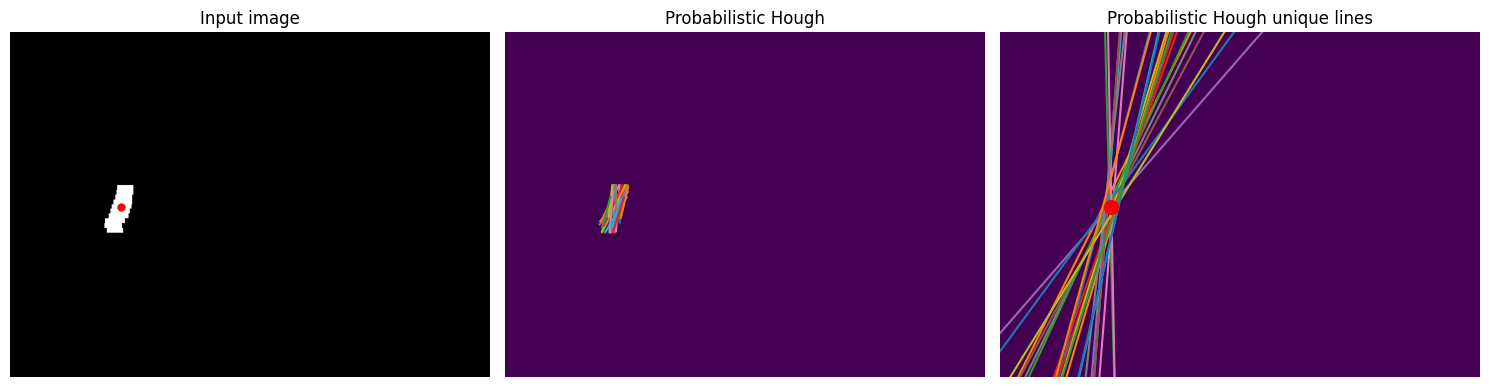

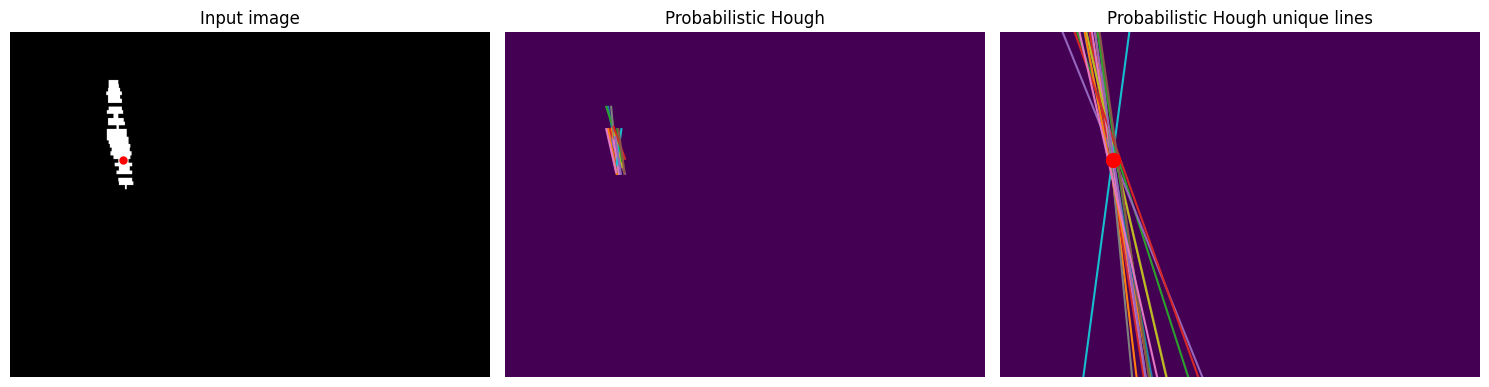

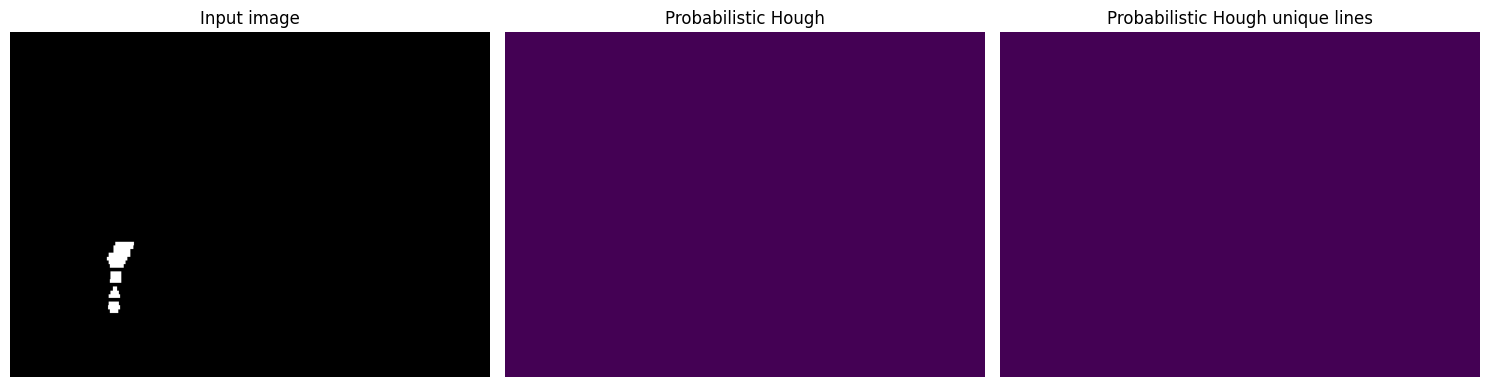

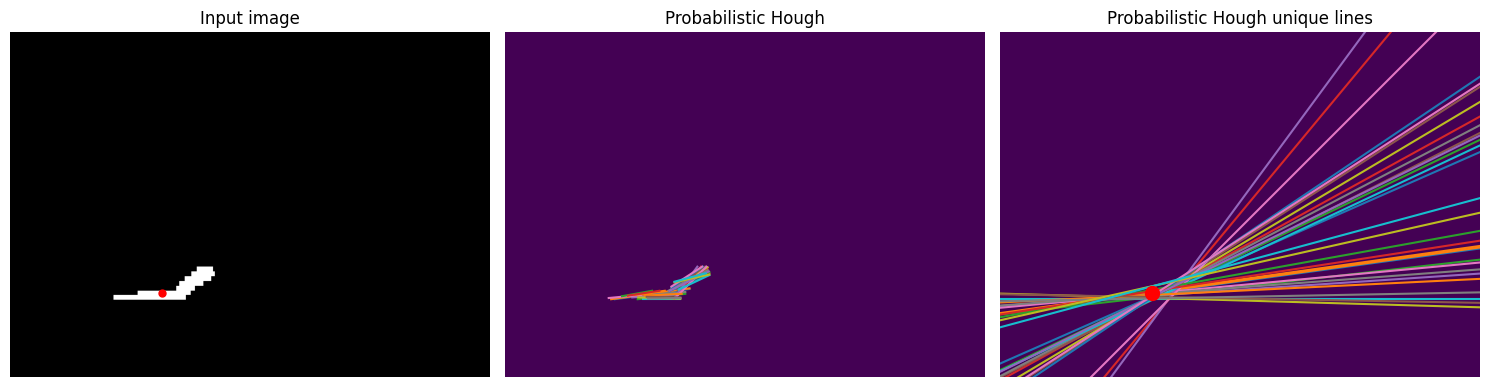

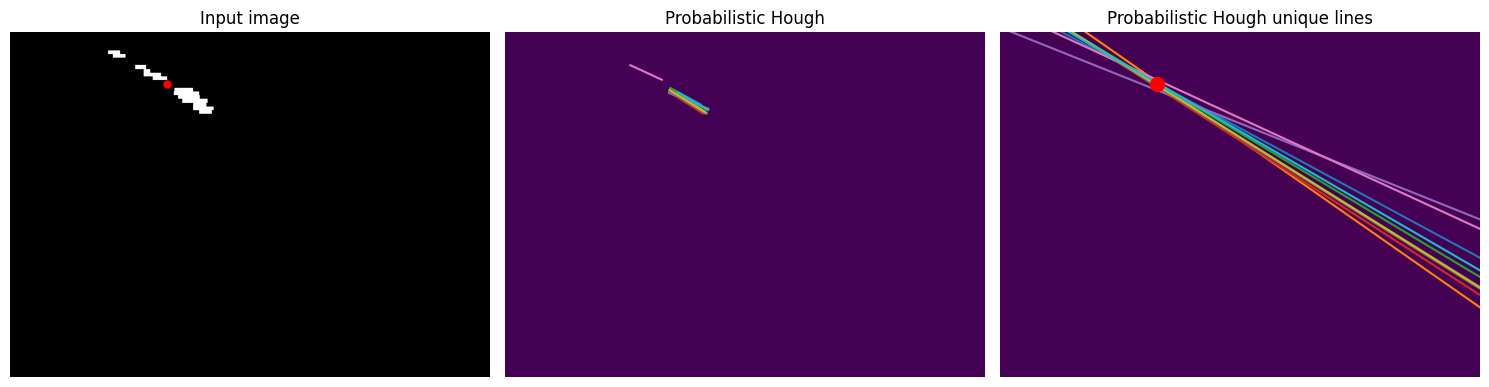

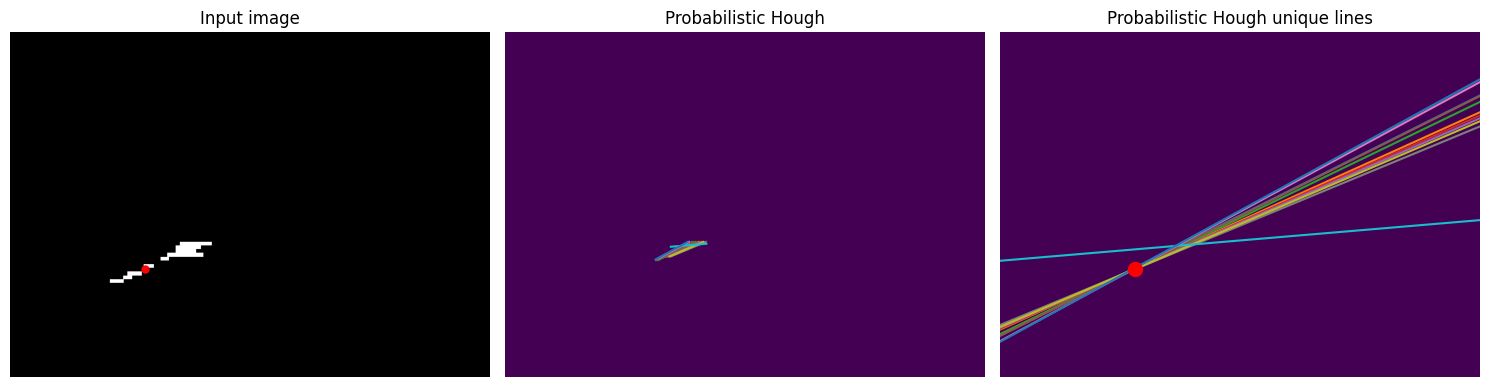

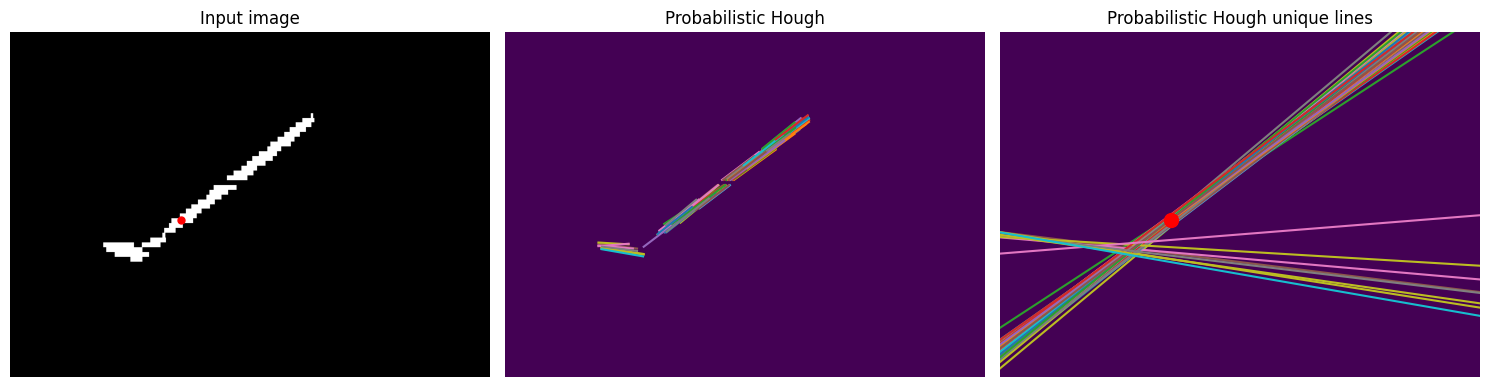

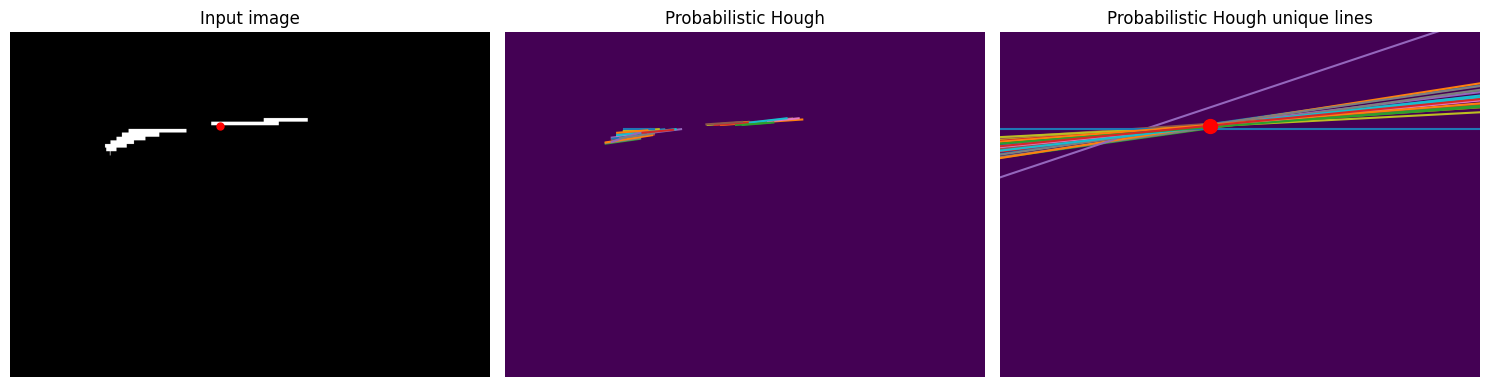

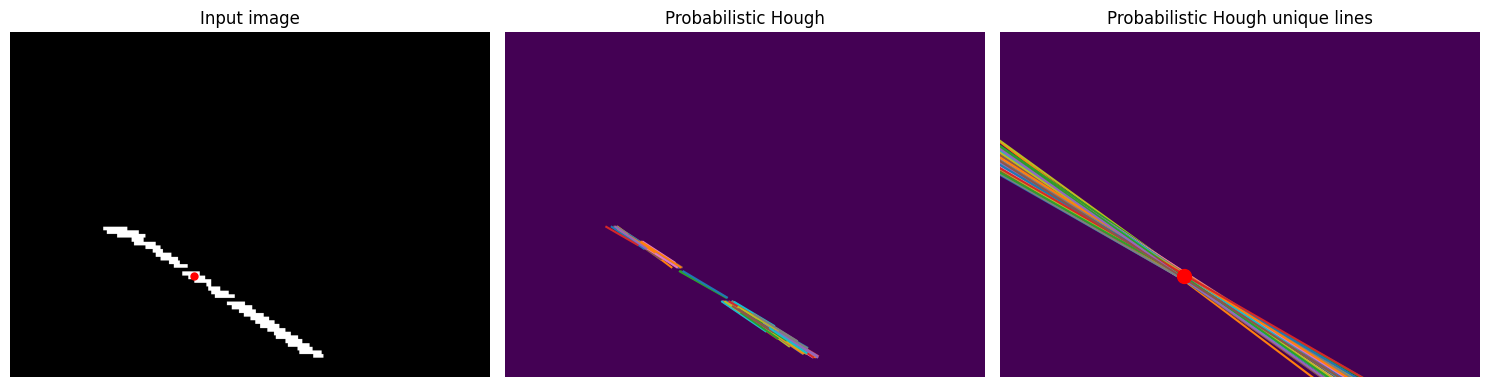

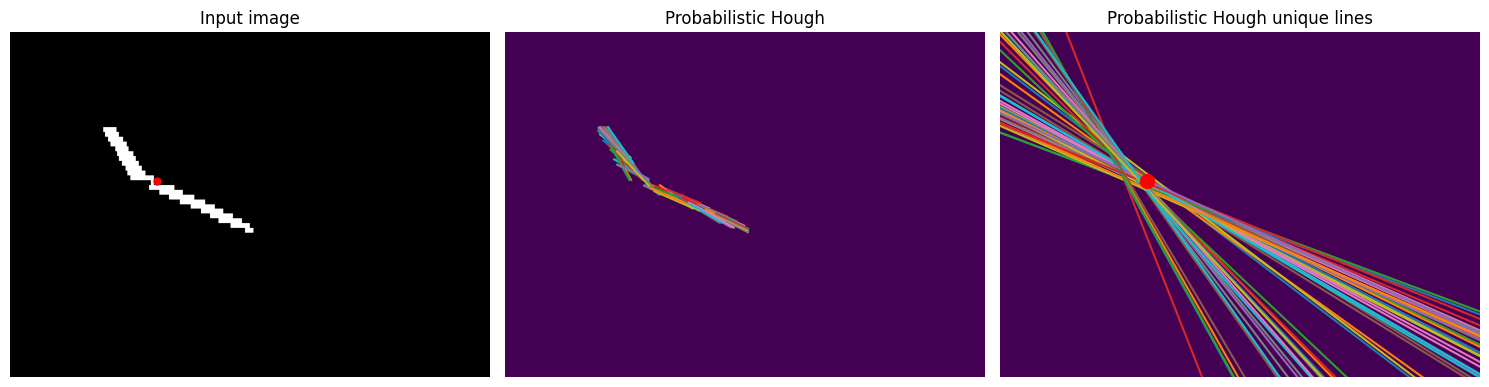

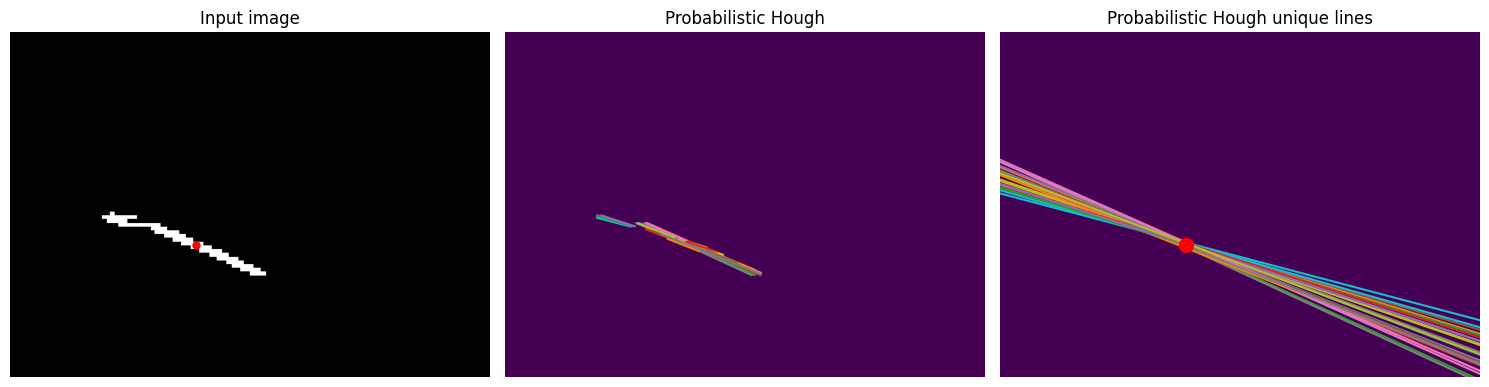

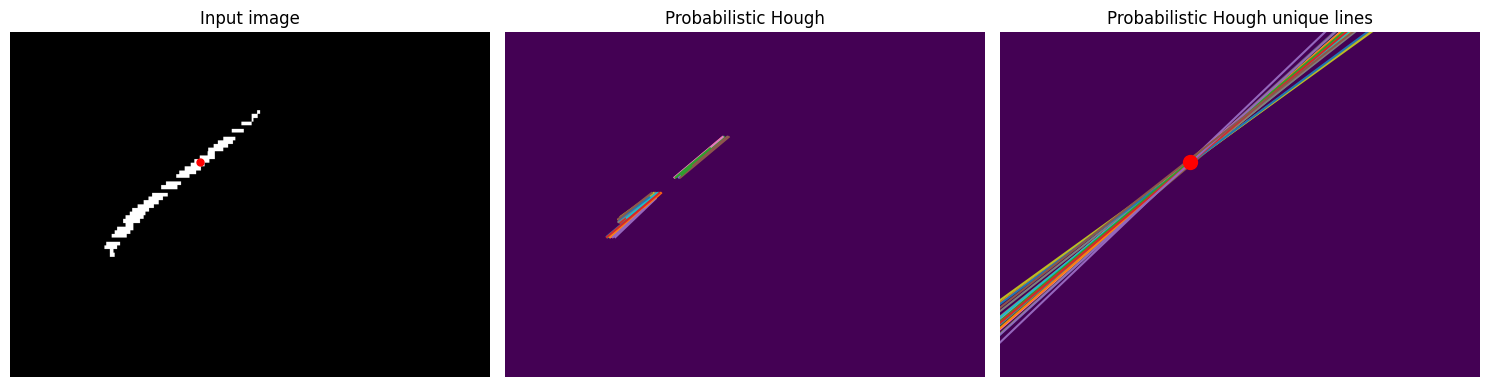

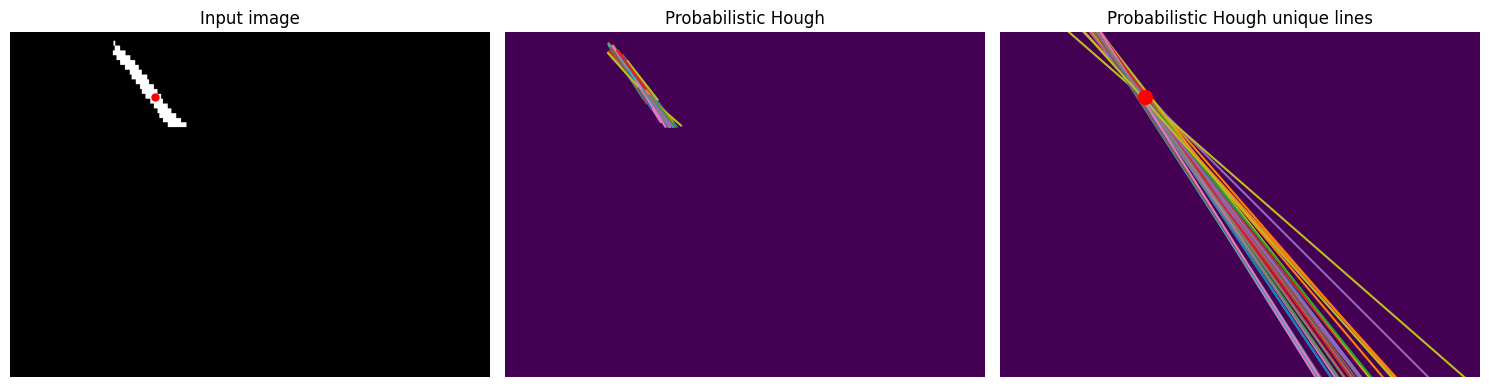

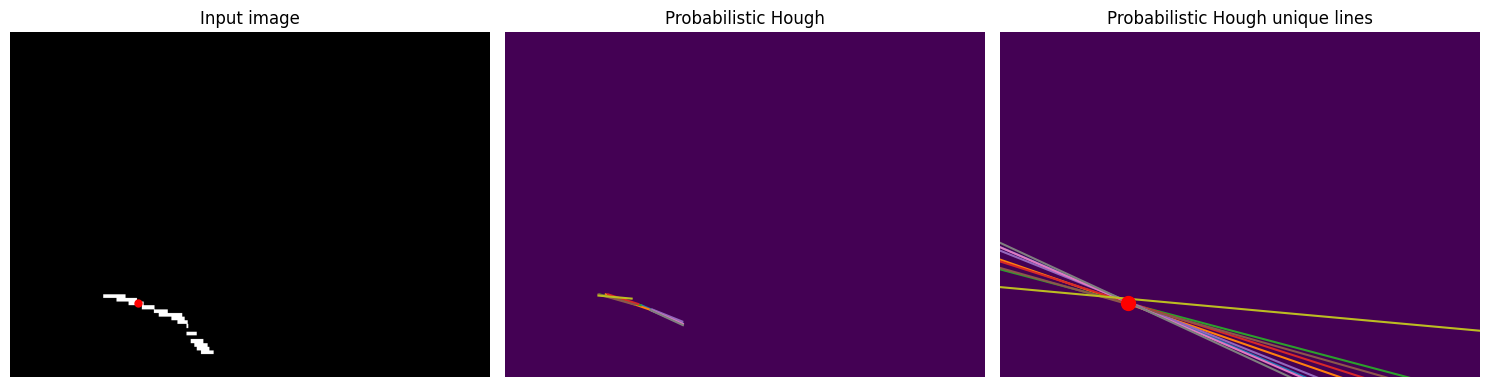

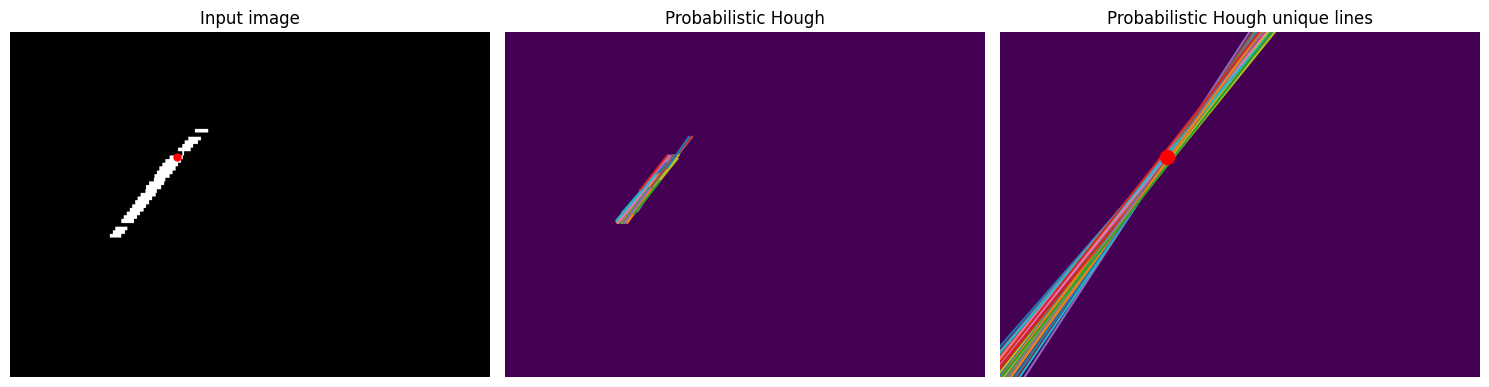

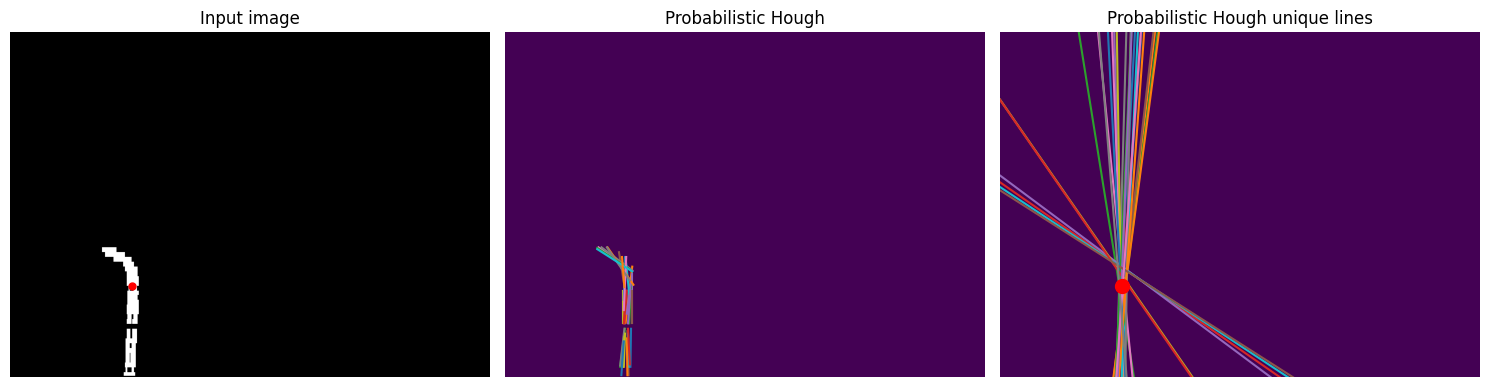

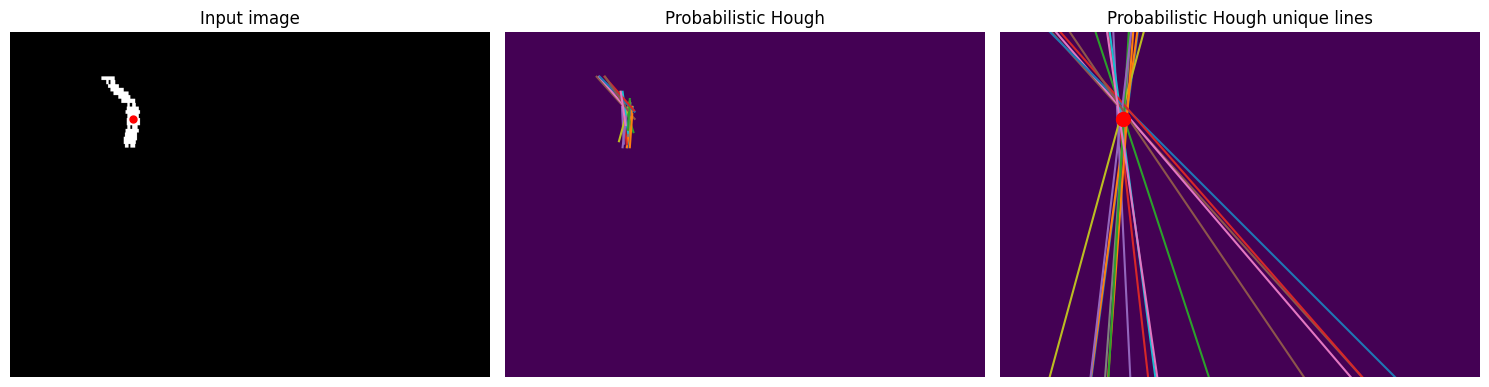

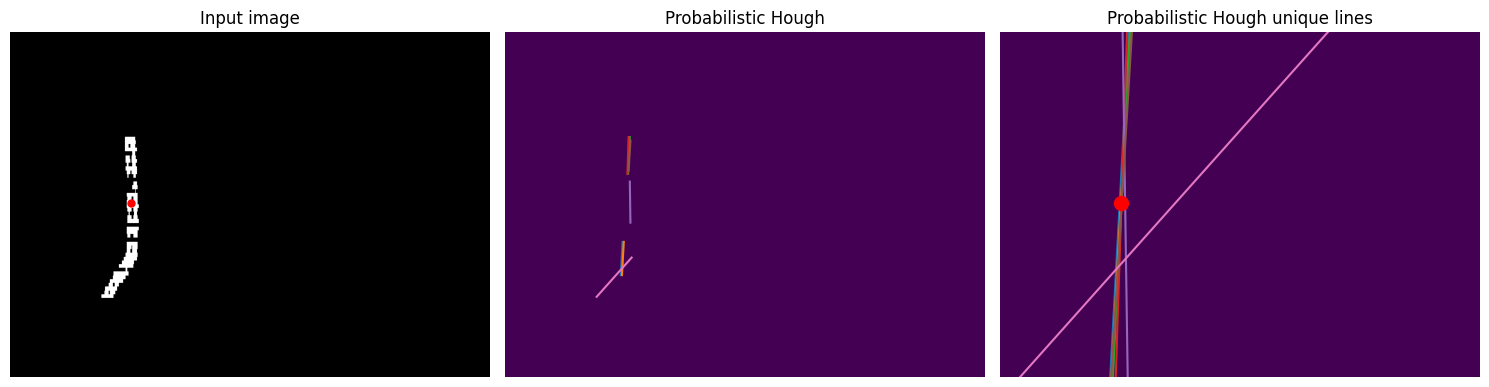

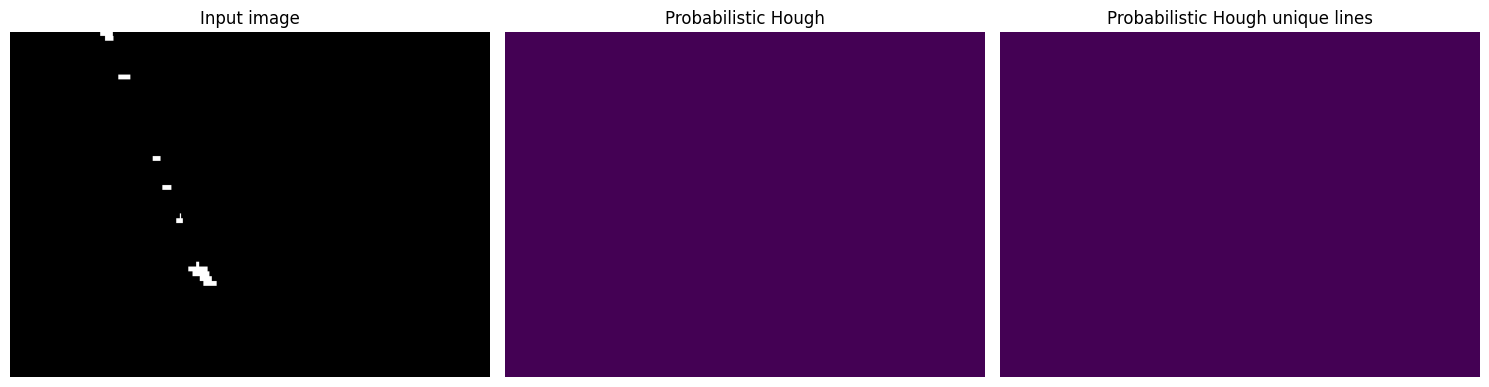

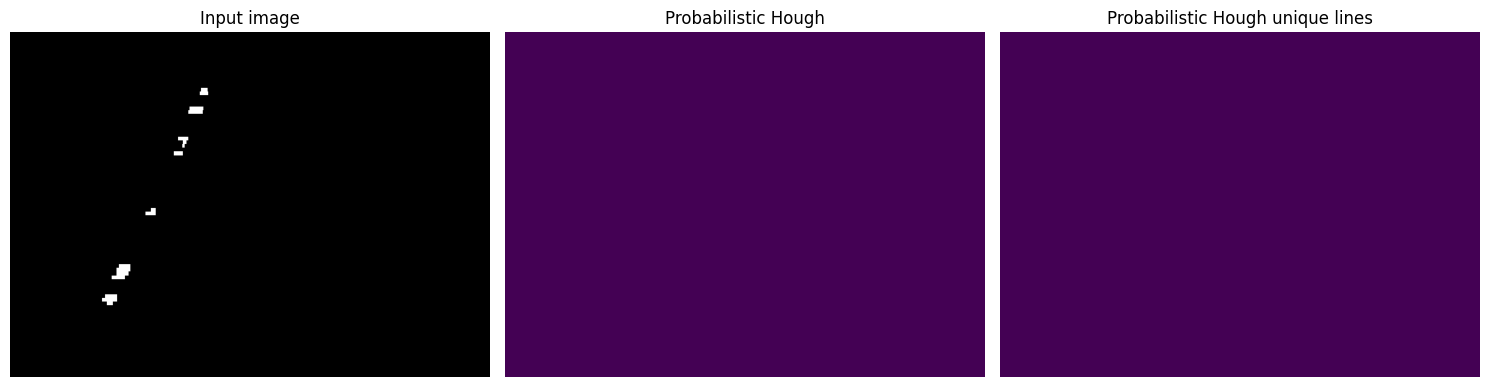

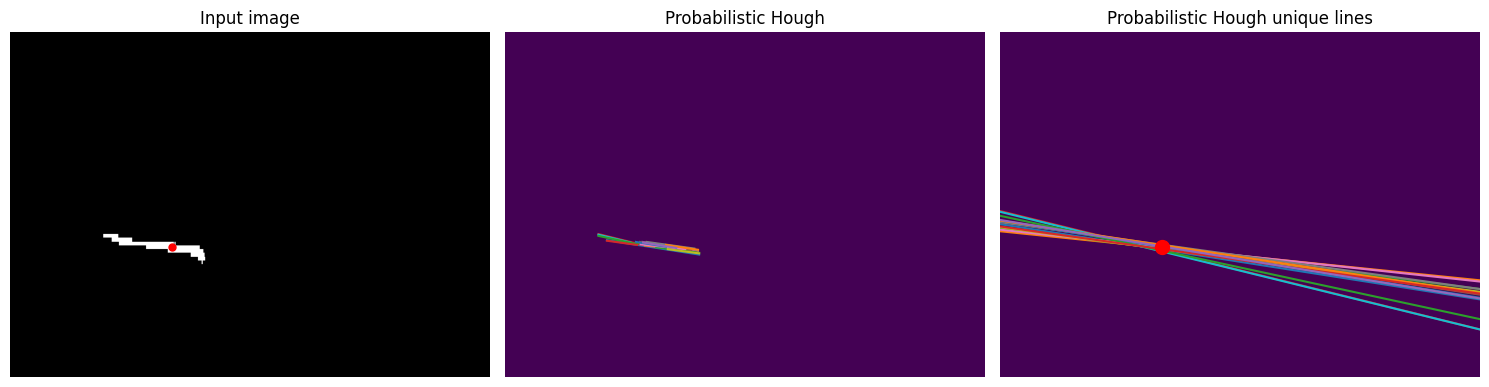

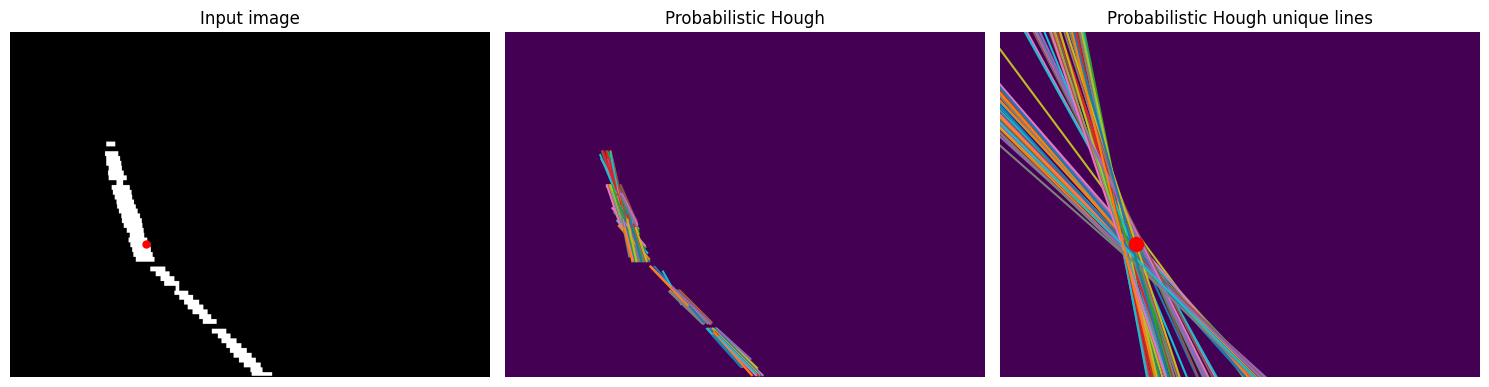

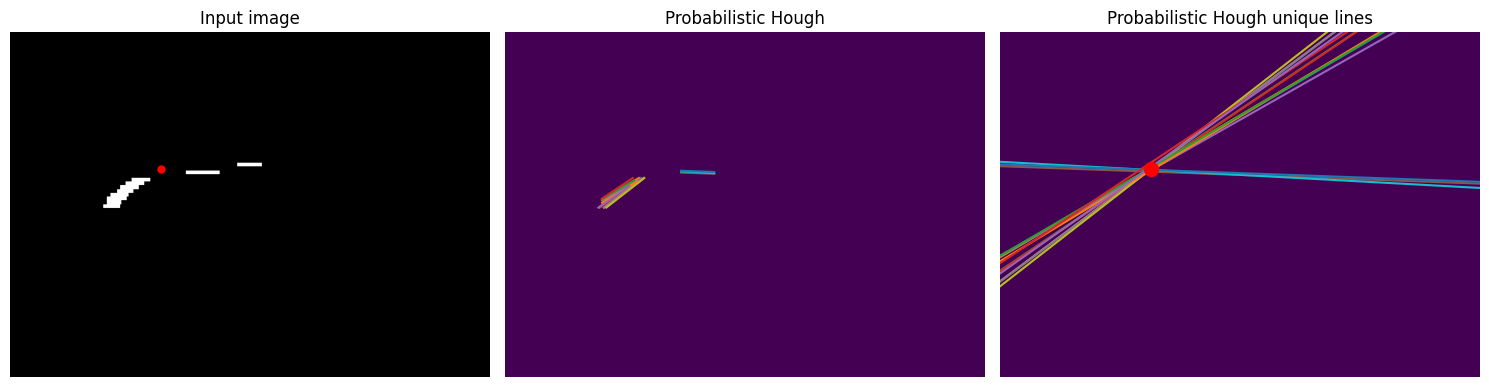

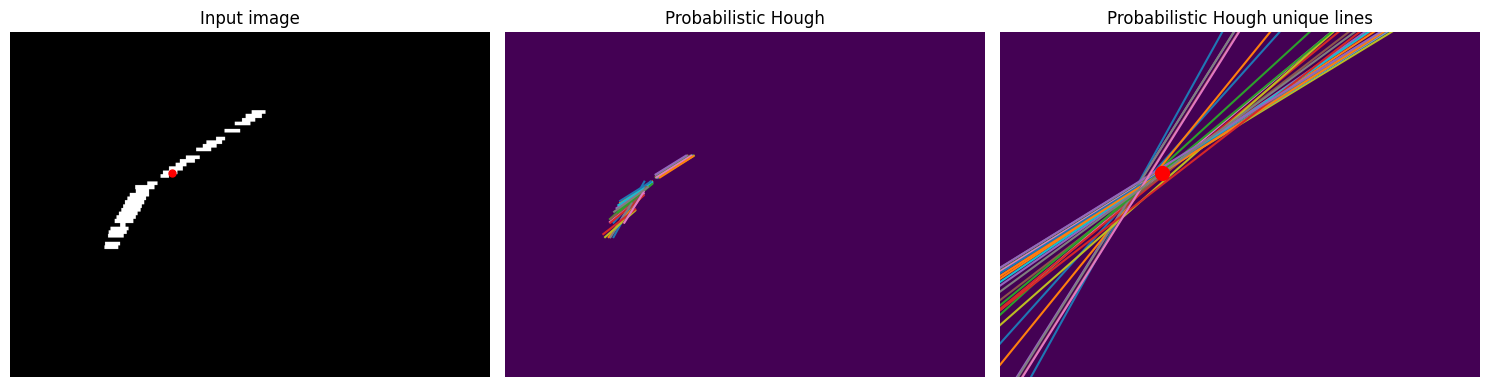

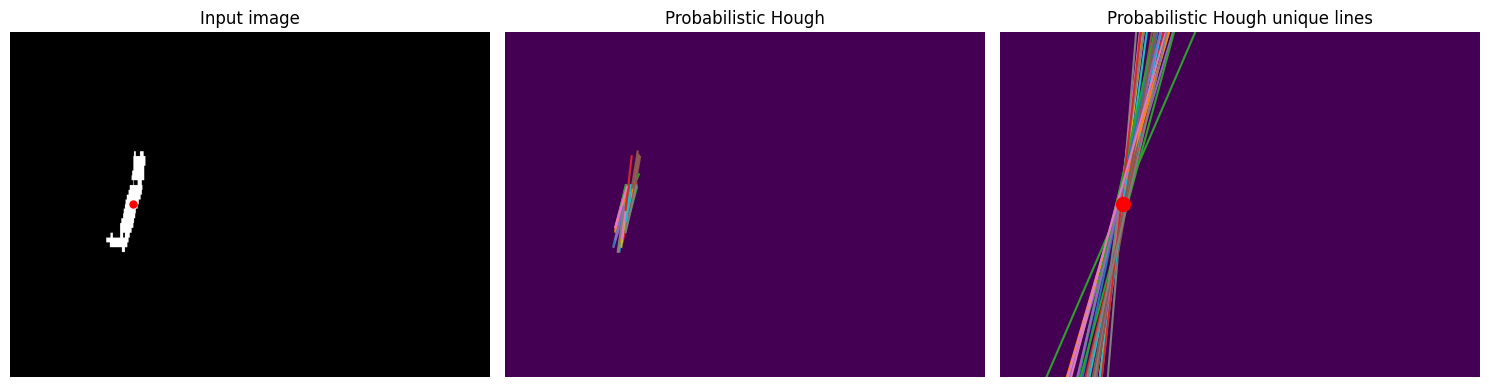

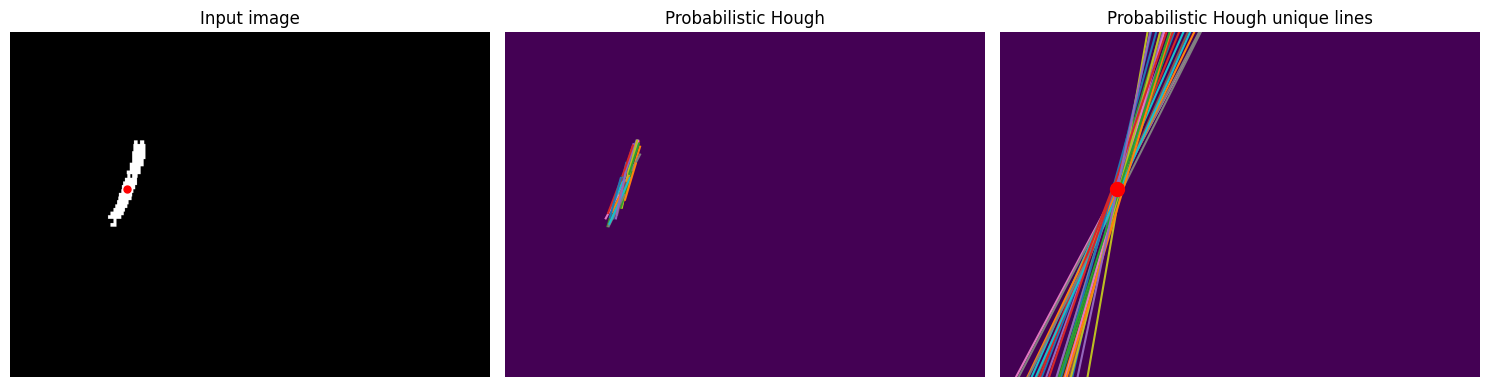

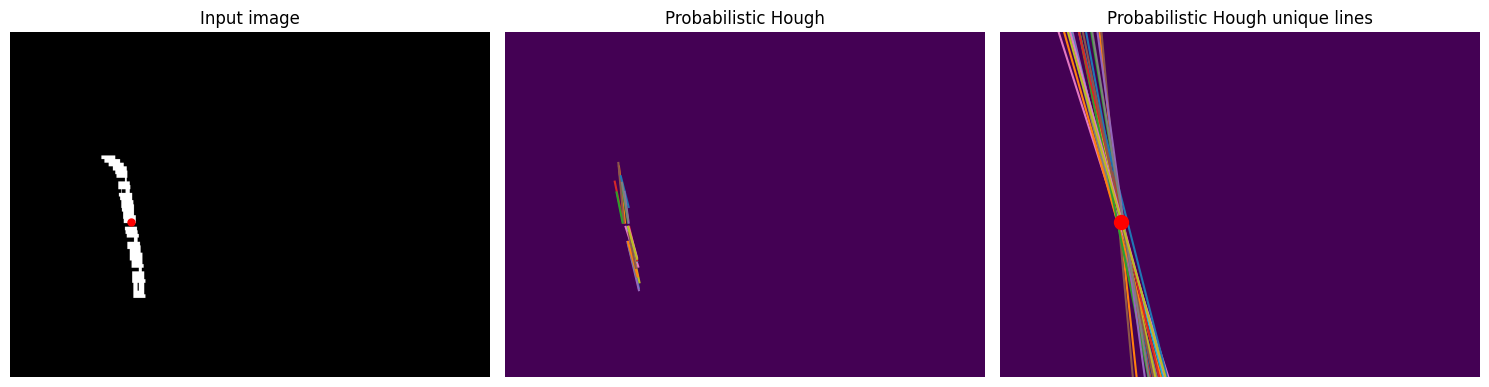

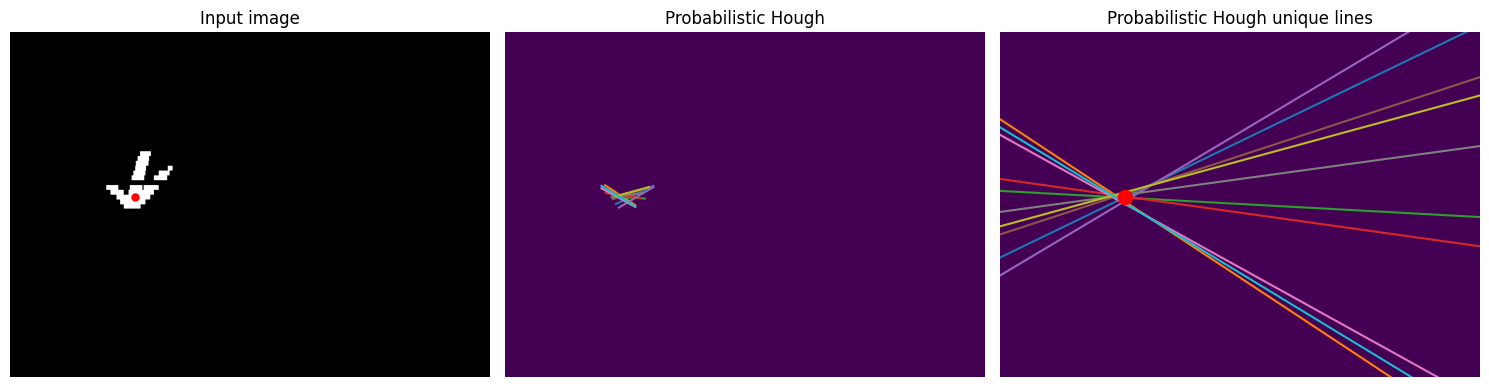

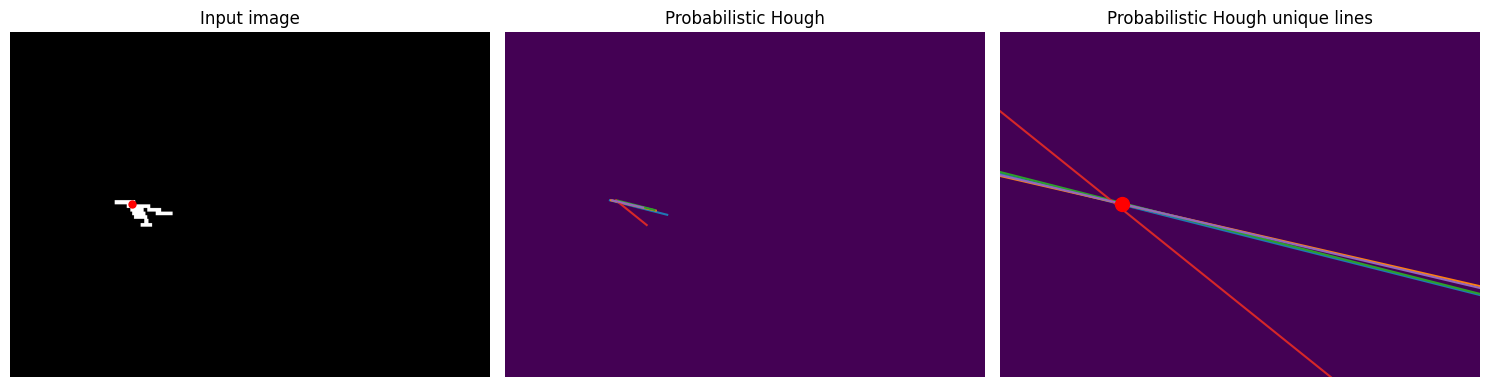

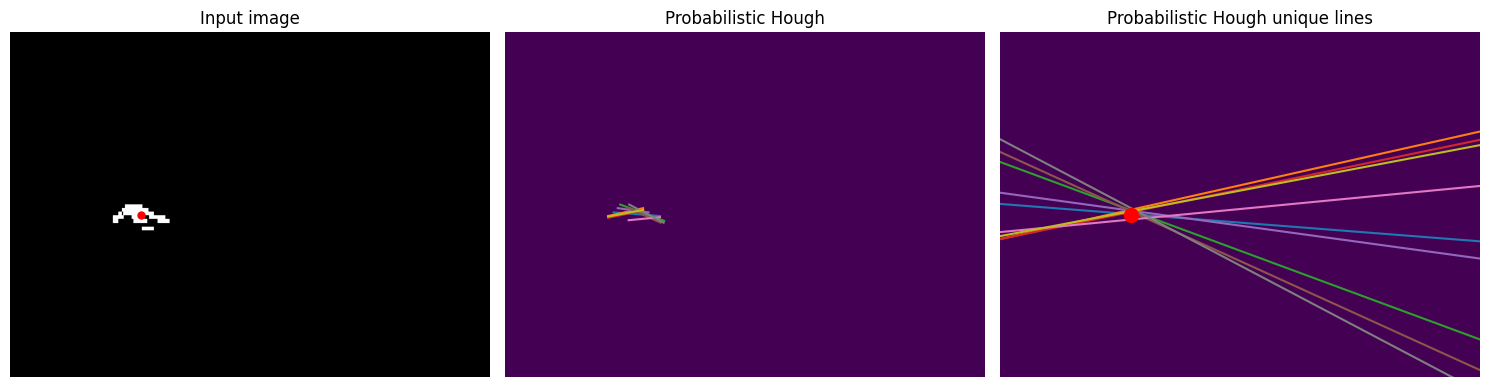

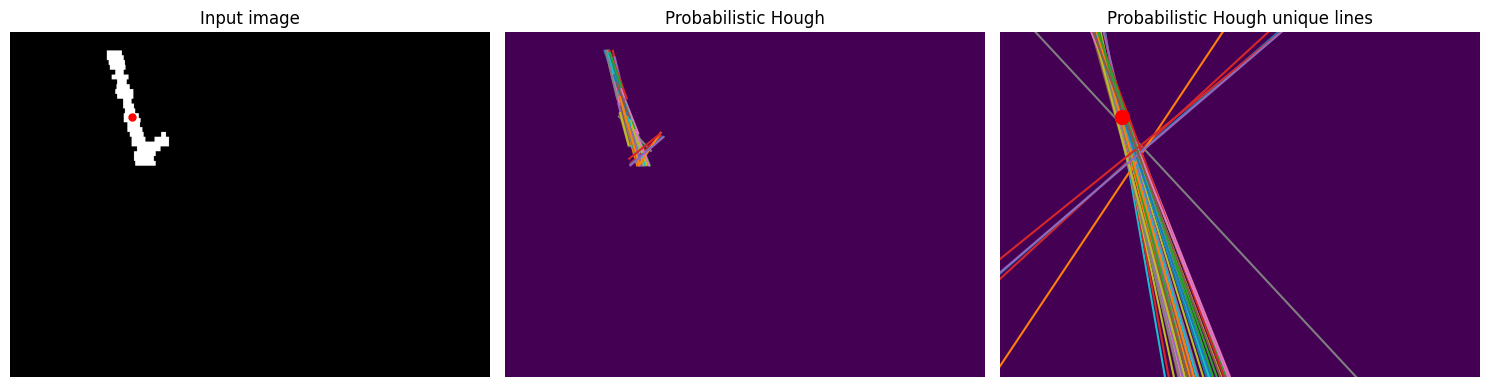

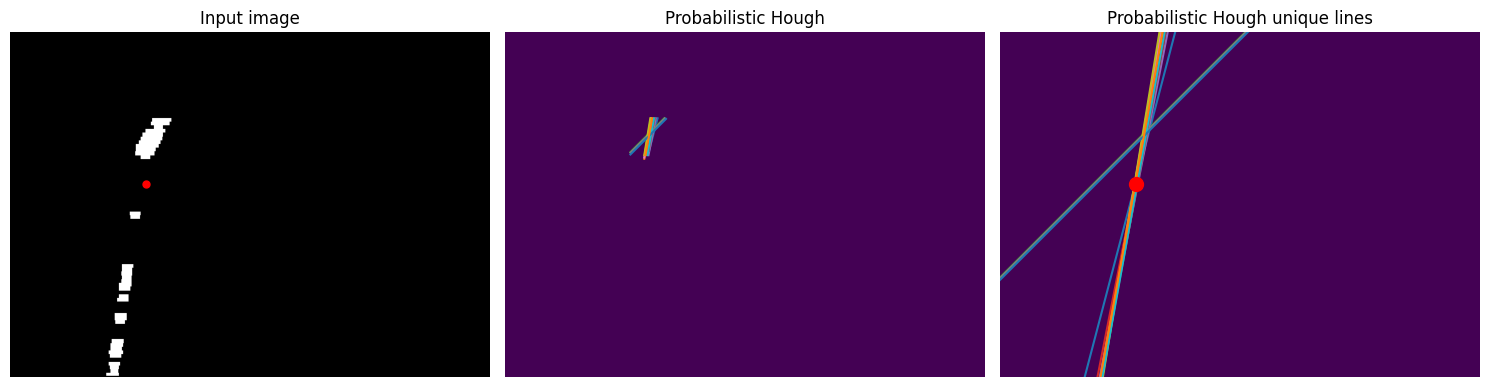

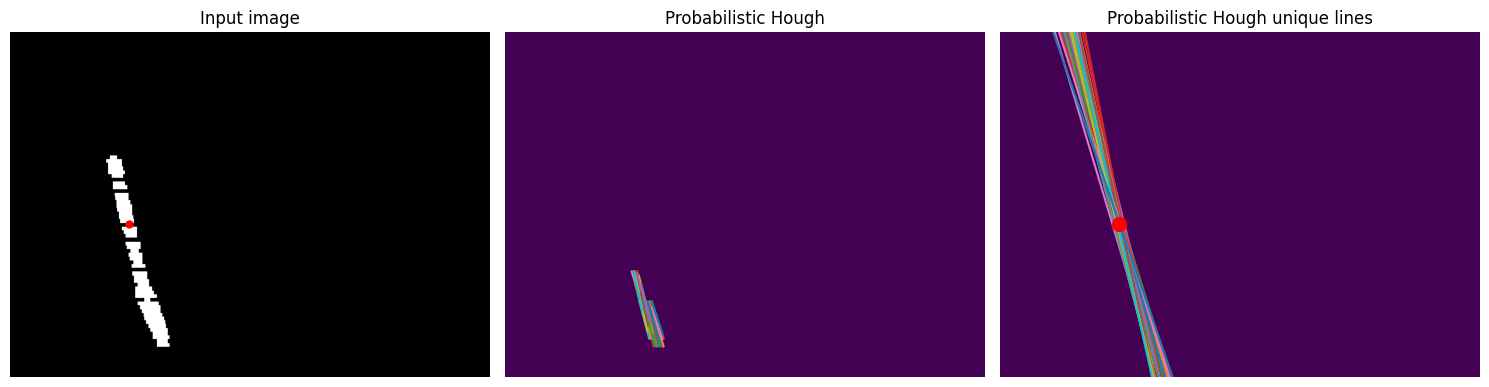

In [18]:
from skimage.morphology import skeletonize
from skimage.color import rgb2gray
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from src.openImage import openImage
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, FundamentalMatrixTransform

# Remove small shapes.
def cleanNoise(image, min_size_threshold=100):

    # Apply a different label for each shape.
    labeled_image, num_labels = ndimage.label(image)

    # Count the size of each labes which is the size of each shape. Remember to address the fact that 0 is not a real label and is background.
    sizes = np.bincount(labeled_image.ravel())

    # Exclude the background label (0) from the sizes array.
    sizes[0] = 0

    # Remove small connected components
    filtered_image = np.where(sizes[labeled_image] < min_size_threshold, 0, 1)

    return filtered_image

def get_slope_intercept(p0, p1):
    if p1[0] - p0[0] != 0:
        slope = (p1[1] - p0[1]) / (p1[0] - p0[0])
    else:
        slope = float('inf')

    intercept = p0[1] - slope * p0[0]

    return slope, intercept

def fitImage(path_and_name_input, path_and_name_output=None):

    ################### PARAMETERS TO BE CHANGED ###################
    white_th=0.15
    threshold=10
    line_length=50
    line_gap=3
    slopes_th = 0.1
    ##############################################################

    


   
    test_image = openImage(path_and_name_input)
    test_image.readImage()

    original_image = test_image.m_data

    # Black and white
    test_image.m_data = rgb2gray(test_image.m_data)

    grey_image = test_image.m_data

    test_image.m_data = np.where(test_image.m_data < white_th, 0, 1)

    test_image.m_data = cleanNoise(test_image.m_data, 100)
    #test_image.m_data = skeletonize(test_image.m_data)

    # Figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(test_image.m_data, cmap=cm.gray)
    ax[0].set_title('Input image')

    ax[1].imshow(test_image.m_data * 0)

    if(np.count_nonzero(test_image.m_data) < 10):
        print(f"At {path_and_name_input} non 0 elements: {np.count_nonzero(test_image.m_data)}\n")
        return

    # Start computations
    lines = probabilistic_hough_line(test_image.m_data, threshold=threshold, line_length=line_length,
                                 line_gap=line_gap, seed=0)
    
    line_s_i_format = []

    for line in lines:
        p0, p1 = line

        ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))

        line_s_i_format.append(get_slope_intercept(p0, p1))

    ax[1].set_xlim((0, test_image.m_data.shape[1]))
    ax[1].set_ylim((test_image.m_data.shape[0], 0))
    ax[1].set_title('Probabilistic Hough')


    unique_lines = []


    """ for slope, intercept in line_s_i_format:
        if unique_lines == False:
            unique_lines.append((slope, intercept))
            #print(f"Slope is {slope}\n")
        else:
            if all(abs(slope - unique_slope) > slopes_th for unique_slope, _ in unique_lines):
                unique_lines.append((slope, intercept)) """
                #print(f"Slope is {slope}\n")

    unique_lines = line_s_i_format


    ax[2].imshow(test_image.m_data * 0)
    ax[2].set_xlim((0, test_image.m_data.shape[1]))
    ax[2].set_ylim((test_image.m_data.shape[0], 0))
    ax[2].set_title('Probabilistic Hough unique lines')

    x = np.linspace(0, test_image.m_data.shape[1], 100)

    for slope, intercept in unique_lines:
        if(slope != float('inf')):
            y = slope * x + intercept
            ax[2].plot(x, y)


    intersections = []

    for i, (slope1, intercept1) in enumerate(unique_lines):
        for slope2, intercept2 in unique_lines[i + 1:]:
            if slope1 != slope2:  # Lines are not parallel
                x = (intercept2 - intercept1) / (slope1 - slope2)
                y = slope1 * x + intercept1
                if (x > 0 and x < 800 and y > 0 and y < 600):
                    intersections.append((x, y))

    if (len(intersections) != 0):
        average_x = sum(
            map(lambda point: point[0], intersections)) / len(intersections)
        average_y = sum(
            map(lambda point: point[1], intersections)) / len(intersections)
            

        ax[2].plot(average_x, average_y, marker='o',
                    markersize=10, color='red')
        ax[0].plot(average_x, average_y, marker='o', markersize=5, color='red')

    for a in ax:
        a.set_axis_off()

    plt.tight_layout()
    # plt.show()
    plt.savefig(path_and_name_output)


##### MAIN #####

image_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages_bw/"

image_list = ["CoBo_2018-06-20T10-51-39.459_0000/25",
              "CoBo_2018-06-20T10-51-39.459_0002/511",
              "CoBo_2018-06-20T10-51-39.459_0002/672",
              "CoBo_2018-06-20T10-51-39.459_0002/1019",
              "CoBo_2018-06-20T10-51-39.459_0003/1319",
              "CoBo_2018-06-20T10-51-39.459_0003/1428",
              "CoBo_2018-06-20T10-51-39.459_0004/114",
              "CoBo_2018-06-20T10-51-39.459_0004/319",
              "CoBo_2018-06-20T10-51-39.459_0004/417",
              "CoBo_2018-06-20T10-51-39.459_0004/448",
              "CoBo_2018-06-20T10-51-39.459_0004/1456",
              "CoBo_2018-06-20T10-51-39.459_0004/1596",
              "CoBo_2018-06-20T10-51-39.459_0004/1725",
              "CoBo_2018-06-20T10-51-39.459_0005/477",
              "CoBo_2018-06-20T10-51-39.459_0005/677",
              "CoBo_2018-06-20T10-51-39.459_0005/1113",
              "CoBo_2018-06-20T10-51-39.459_0005/1190",
              "CoBo_2018-06-20T10-51-39.459_0005/1311",
              "CoBo_2018-06-20T10-51-39.459_0005/1843"]

image_suffix_list = ["_u.png", "_v.png", "_w.png"]


output_path = "/media/gant/Expansion/tpc_root_raw/DATA_ROOT/imagesavgpoint/"


for image in image_list:
    for suffix in image_suffix_list:
        fitImage((image_path + image + suffix), (output_path + image + suffix))